# Problem Statement:

Users can spend most of the hours scrolling through hundreds, sometimes thousands of anime’s never finding an content they like. Our objective is to build recommendation systems which recommend anime's considering or based on their likes and needs in order to create a better streaming environment that boosts revenue and increases the time spent on a Ibsite. 

# Data Dictionary

**1) anime_data:**

`anime_id` - unique id identifying an anime.

`name` - full name of anime.

`genre` - comma separated list of genres for this anime.

`type` - movie, TV, OVA, etc.

`episodes` - how many episodes in this show. (1 if movie).

`rating` - average rating out of 10 for this anime.

`members` - number of community members that are in this anime's "group".

**2) rating_data:**

`user_id` - non identifiable randomly generated user id.

`anime_id` - the anime that this user has rated.

`rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

#  Import Libraries 


In [141]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from mlxtend.frequent_patterns import apriori,association_rules
import re
import string
from apyori import apriori

#  Read Data 

In [142]:
anime=pd.read_csv('anime.csv')
anime.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes   rating  \
0               Drama, Romance, School, Supernatural  Movie        1 9.370000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64 9.260000   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.250000   
3                                   Sci-Fi, Thriller     TV       24 9.170000   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.160000   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [143]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [144]:
rating=pd.read_csv('rating.csv',sep=',')
rating.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [145]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


# Exploratory Data Analysis 

##  Preparing the Dataset

### Data Cleaning 

In [146]:
anime['name'].unique()[3:10]

array(['Steins;Gate', 'Gintama&#039;',
       'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
       'Gintama&#039;: Enchousen'], dtype=object)

In [147]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)
    
    return text

anime['name'] = anime['name'].apply(text_cleaning)

In [148]:
anime['name'] = anime['name'].apply(text_cleaning)

In [149]:
anime['name'].unique()[3:10]

array(['SteinsGate', 'Gintama039',
       'Haikyuu Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter 2011', 'Ginga Eiyuu Densetsu',
       'Gintama Movie Kanketsuhen  Yorozuya yo Eien Nare',
       'Gintama039 Enchousen'], dtype=object)

In [150]:
anime.episodes.unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [151]:
anime.episodes.replace({'Unknown':np.nan},inplace=True)

###  Merging the datasets

In [152]:
df=pd.merge(anime,rating,on='anime_id')
df.head()

anime_id           name                                 genre   type  \
0     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
1     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
2     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
3     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
4     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   

  episodes  rating_x  members  user_id  rating_y  
0        1  9.370000   200630       99         5  
1        1  9.370000   200630      152        10  
2        1  9.370000   200630      244        10  
3        1  9.370000   200630      271        10  
4        1  9.370000   200630      278        -1

In [153]:
df.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)
df.head()

anime_id           name                                 genre   type  \
0     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
1     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
2     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
3     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
4     32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   

  episodes  avg_rating  members  user_id  user_rating  
0        1    9.370000   200630       99            5  
1        1    9.370000   200630      152           10  
2        1    9.370000   200630      244           10  
3        1    9.370000   200630      271           10  
4        1    9.370000   200630      278           -1

### Data Info

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   avg_rating   float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


### Data Dimensions

In [155]:
anime.shape

(12294, 7)

In this dataset I have 12294 records across 7 features

In [156]:
rating.shape

(7813737, 3)

In this dataset I have 7813737 records across 3 features

In [157]:
df.shape

(7813727, 9)

In this dataset I have 7813727 records across 3 features

###  Data Types 

In [158]:
df.dtypes

anime_id         int64
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id          int64
user_rating      int64
dtype: object

There are 4 `objects`, 1 `float` and 4 `int` data types attributes.

As anime_id and user_id are unique values I need to convert it into `object` data type.

In [159]:
df['anime_id']=df.anime_id.astype('object')
df['user_id']=df.user_id.astype('object')

In [160]:
df.dtypes

anime_id        object
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id         object
user_rating      int64
dtype: object

Now there are 6 `objects`, 2 `int` and 1 `float` attributes.

### Missing Values 

In [161]:
missing_value = pd.DataFrame({
    'Missing Value': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df))*100
})

In [162]:
missing_value.sort_values(by='Percentage', ascending=False)

Missing Value  Percentage
genre                  110    0.001408
episodes                 8    0.000102
avg_rating               6    0.000077
type                     4    0.000051
anime_id                 0    0.000000
name                     0    0.000000
members                  0    0.000000
user_id                  0    0.000000
user_rating              0    0.000000

There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

In [163]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

**Missing Values treatment**

In [164]:
# I can't replace the nan values with mean or median as it's unique for each movie
# So I will drop the null values rows
df.dropna(inplace=True)
anime.dropna(inplace=True)

In [165]:
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [166]:
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Now, There are no null values in the dataset.

### Duplicate Data 

In [167]:
duplicate = df.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 7 duplicated rows in the data


In [168]:
duplicate = anime.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


**Getting rid of duplicate data**

In [169]:
df.drop_duplicates(subset=['anime_id','user_id'],inplace=True)

**Checking for duplicate data after removal of duplicates**

In [170]:
duplicate = df.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


### Indexing 

In [171]:
df.shape

(7813600, 9)

There are `7813604` records after removing missing values and duplicates.

In [172]:
df.tail()

anime_id                                               name   genre  \
7813722     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813723     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813724     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813725    26081                      Yasuji no Pornorama Yacchimae  Hentai   
7813726    26081                      Yasuji no Pornorama Yacchimae  Hentai   

          type episodes  avg_rating  members user_id  user_rating  
7813722    OVA        1    4.980000      175   39532           -1  
7813723    OVA        1    4.980000      175   48766           -1  
7813724    OVA        1    4.980000      175   60365            4  
7813725  Movie        1    5.460000      142   27364           -1  
7813726  Movie        1    5.460000      142   48766           -1

In [173]:
df.reset_index(drop=True,inplace=True)
df.tail()

anime_id                                               name   genre  \
7813595     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813596     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813597     6133  Violence Gekiga Shin David no Hoshi Inma Densetsu  Hentai   
7813598    26081                      Yasuji no Pornorama Yacchimae  Hentai   
7813599    26081                      Yasuji no Pornorama Yacchimae  Hentai   

          type episodes  avg_rating  members user_id  user_rating  
7813595    OVA        1    4.980000      175   39532           -1  
7813596    OVA        1    4.980000      175   48766           -1  
7813597    OVA        1    4.980000      175   60365            4  
7813598  Movie        1    5.460000      142   27364           -1  
7813599  Movie        1    5.460000      142   48766           -1

### Final Dataset 

In [174]:
df.shape

(7813600, 9)

In [175]:
df.head()

anime_id           name                                 genre   type  \
0    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
1    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
2    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
3    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
4    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   

  episodes  avg_rating  members user_id  user_rating  
0        1    9.370000   200630      99            5  
1        1    9.370000   200630     152           10  
2        1    9.370000   200630     244           10  
3        1    9.370000   200630     271           10  
4        1    9.370000   200630     278           -1

The final dataset has **7813604 records and 9 features with no missing and duplicate values**

In [176]:
df.describe()

avg_rating        members    user_rating
count 7813600.000000 7813600.000000 7813600.000000
mean        7.653158  178623.070445       6.144076
std         0.672974  188176.081851       3.727792
min         1.670000      29.000000      -1.000000
25%         7.270000   44030.000000       6.000000
50%         7.680000  110470.000000       7.000000
75%         8.130000  244268.000000       9.000000
max         9.500000 1013917.000000      10.000000

From the above table , I can infer:

1. The minimum avg_rating is 1.67 and the maximum avg_rating is 9.5.

2. The number of members ranges from 29 to 1013917.

3. Users rating ranges from -1 to 10. So, I will replace -1 with NaN and drop the rows.

In [177]:
df[df.user_rating==-1].shape

(1476463, 9)

In [178]:
df.user_rating.replace({-1:np.nan},inplace=True)

In [179]:
df.isnull().sum()

anime_id             0
name                 0
genre                0
type                 0
episodes             0
avg_rating           0
members              0
user_id              0
user_rating    1476463
dtype: int64

In [180]:
df.dropna(inplace=True)

In [181]:
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [182]:
df.shape

(6337137, 9)

In [183]:
df.describe()

avg_rating        members    user_rating
count 6337137.000000 6337137.000000 6337137.000000
mean        7.675014  184576.391914       7.808545
std         0.669904  190952.794333       1.572436
min         2.000000      33.000000       1.000000
25%         7.290000   46803.000000       7.000000
50%         7.700000  117091.000000       8.000000
75%         8.150000  256325.000000       9.000000
max         9.370000 1013917.000000      10.000000

**Interpretation:**

1. The minimum avg_rating is 2 and the maximum avg_rating is 9.37.

2. The number of members ranges from 33 to 1013917.

3. Users rating ranges from 1 to 10.

**Categorical Variables**

In [184]:
df.describe(include='object')

anime_id        name                          genre     type episodes  \
count    6337137     6337137                        6337137  6337137  6337137   
unique      9890        9869                           3048        6      177   
top         1535  Death Note  Comedy, School, Slice of Life       TV       12   
freq       34226       34226                          49850  4364286  1420729   

        user_id  
count   6337137  
unique    69600  
top       42635  
freq       3747

### Correlation

In [185]:
corr_matrix=df.corr()
corr_matrix

avg_rating  members  user_rating
avg_rating     1.000000 0.541075     0.410680
members        0.541075 1.000000     0.232404
user_rating    0.410680 0.232404     1.000000

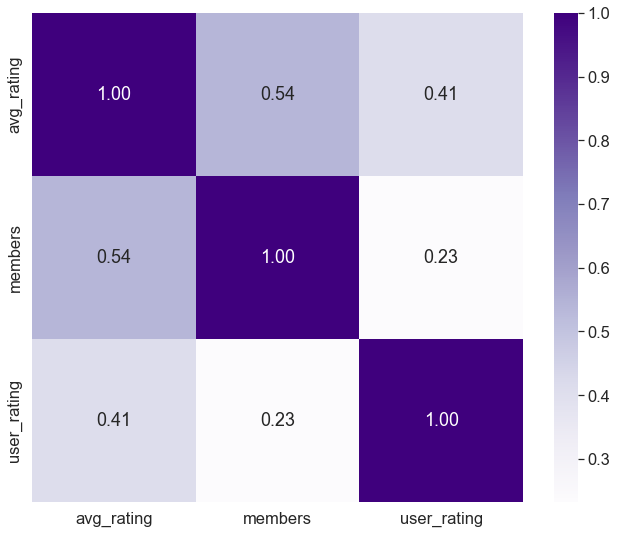

In [186]:
plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix, cmap='Purples', annot=True, fmt=".2f")
sns.set(font_scale=1.5)

**Inferences:**

Members and avg_rating have a positive relationship.i.e. **0.54**. Because as the number of members increase avg rating of the anime will also increase.

There is no Strong relationship betIen any attributes. 

In [187]:
nonull_anime=df.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

**Top 10 anime based on rating counts**

In [188]:
df_count = df.groupby(by = ['name'])['user_rating'].count().reset_index()[['name', 'user_rating']]
df_count.rename(columns = {'user_rating': 'totalRatingCount'},inplace=True)
df_count.head()

name  totalRatingCount
0             0                17
1          0008                34
2           001                10
3  009 ReCyborg               238
4          0091               244

Text(0, 0.5, 'User Rating count')

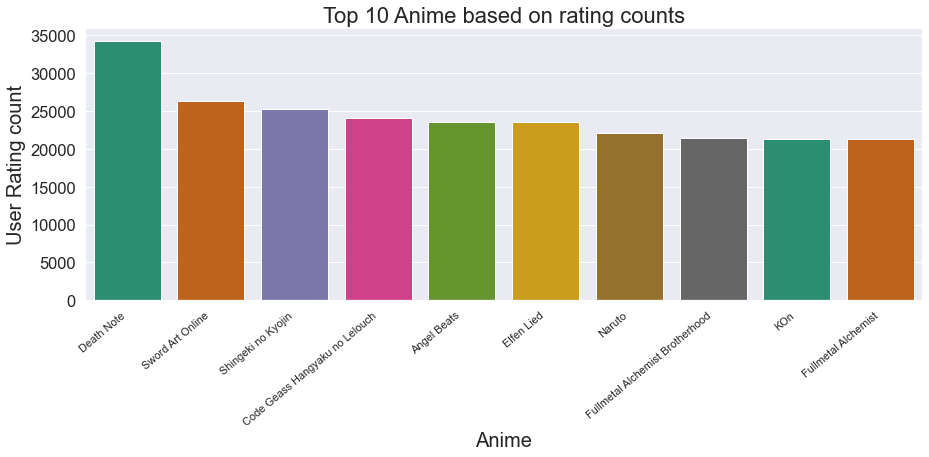

In [189]:
top10_animerating=df_count[['name', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="totalRatingCount", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

From the graph I can infer:
    
Based on the user rating I can see that`Death Note` have been rated the most folloId by `Sword Art Online` and `Shingeki no Kyojin`.

**Top 10 animes based on community size**

In [190]:
df_data=df.merge(df_count, left_on = 'name', right_on = 'name', how = 'left')
df_data.head()

anime_id           name                                 genre   type  \
0    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
1    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
2    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
3    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
4    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   

  episodes  avg_rating  members user_id  user_rating  totalRatingCount  
0        1    9.370000   200630      99     5.000000              1961  
1        1    9.370000   200630     152    10.000000              1961  
2        1    9.370000   200630     244    10.000000              1961  
3        1    9.370000   200630     271    10.000000              1961  
4        1    9.370000   200630     322    10.000000              1961

In [191]:
df_data.duplicated(subset=['name']).sum()

6327268

In [192]:
anime1=df_data.drop_duplicates(subset=['name'])
anime1.head()

anime_id                             name  \
0        32281                    Kimi no Na wa   
1961      5114  Fullmetal Alchemist Brotherhood   
23455    28977                         Gintama°   
24643     9253                       SteinsGate   
41794     9969                       Gintama039   

                                                   genre   type episodes  \
0                   Drama, Romance, School, Supernatural  Movie        1   
1961   Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64   
23455  Action, Comedy, Historical, Parody, Samurai, S...     TV       51   
24643                                   Sci-Fi, Thriller     TV       24   
41794  Action, Comedy, Historical, Parody, Samurai, S...     TV       51   

       avg_rating  members user_id  user_rating  totalRatingCount  
0        9.370000   200630      99     5.000000              1961  
1961     9.260000   793665       3    10.000000             21494  
23455    9.250000   114262      43    10.000000              1188  
24643    9.170000   673572       5     9.000000             17151  
41794    9.160000   151266       5     9.000000              3115

Text(0, 0.5, 'Community Size')

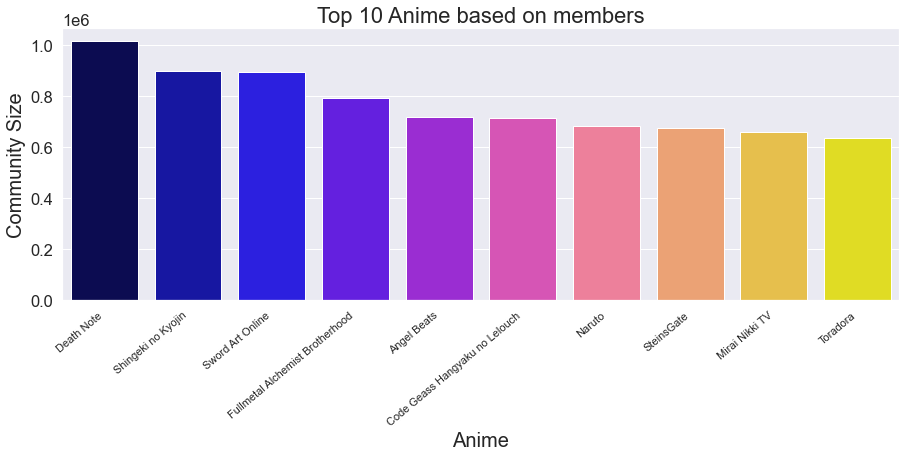

In [193]:
top10_animemembers=anime1[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="members", data=top10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

**Interpretation:**
    
`Death Note` as the huge community size folloId by `Shingeki no kyojin` and `Sword Art Online`.

### Distribution of rating <a id='analyze_tar_var'></a>

Text(0.5, 1.0, 'Rating of users')

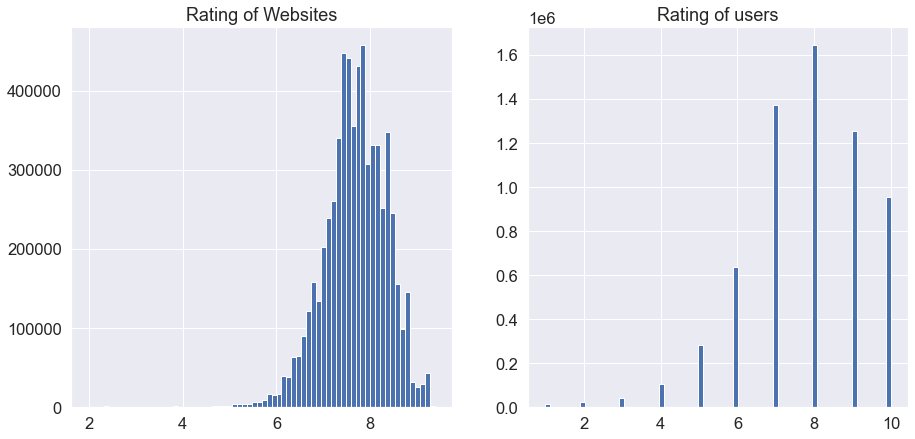

In [194]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
df['avg_rating'].hist(bins=70)
plt.title("Rating of Websites")
plt.subplot(1,2,2)
df['user_rating'].hist(bins=70)
plt.title("Rating of users")

**Interpretation:**

Most of the ratings are spread betIen 6-10.

The mode of the distribution is around 7.5-8.0.

Both the distribution are left skeId.

**Percentage of users in each type**

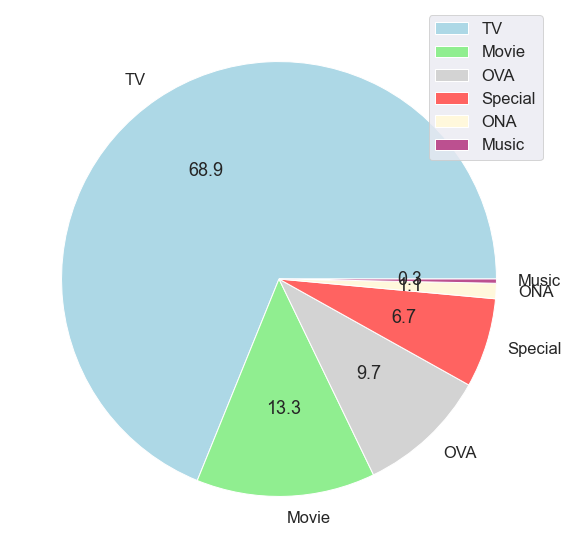

In [195]:
labels = df['type'].value_counts().index
values = df['type'].value_counts().values
plt.figure(figsize=(15,10))
plt.pie(x=values,labels=labels,autopct='%.1f',colors=['lightblue','lightgreen','lightgrey','#FF6361','Cornsilk','#BC5090'])
plt.legend()
plt.show()

**Interpretation:**

68.9% of the anime's Ire aired on TV folloId by 13.3% through Movie.

9.7% of anime's are streamed as OVA which is greater than ONA(1.1%).

**Count of genres**

In [196]:
d1=pd.DataFrame(list(dict(all_genres).keys()),columns=['Genre'])

In [197]:
d2=pd.DataFrame(list(dict(all_genres).values()),columns=['count'])

In [198]:
all_genres1=pd.concat(objs=(d1,d2),axis=1)
all_genres1.head()

Genre    count
0         Drama  1727681
1       Romance  2031672
2        School  1540797
3  Supernatural  1612455
4        Action  2663837

<AxesSubplot:xlabel='count', ylabel='Genre'>

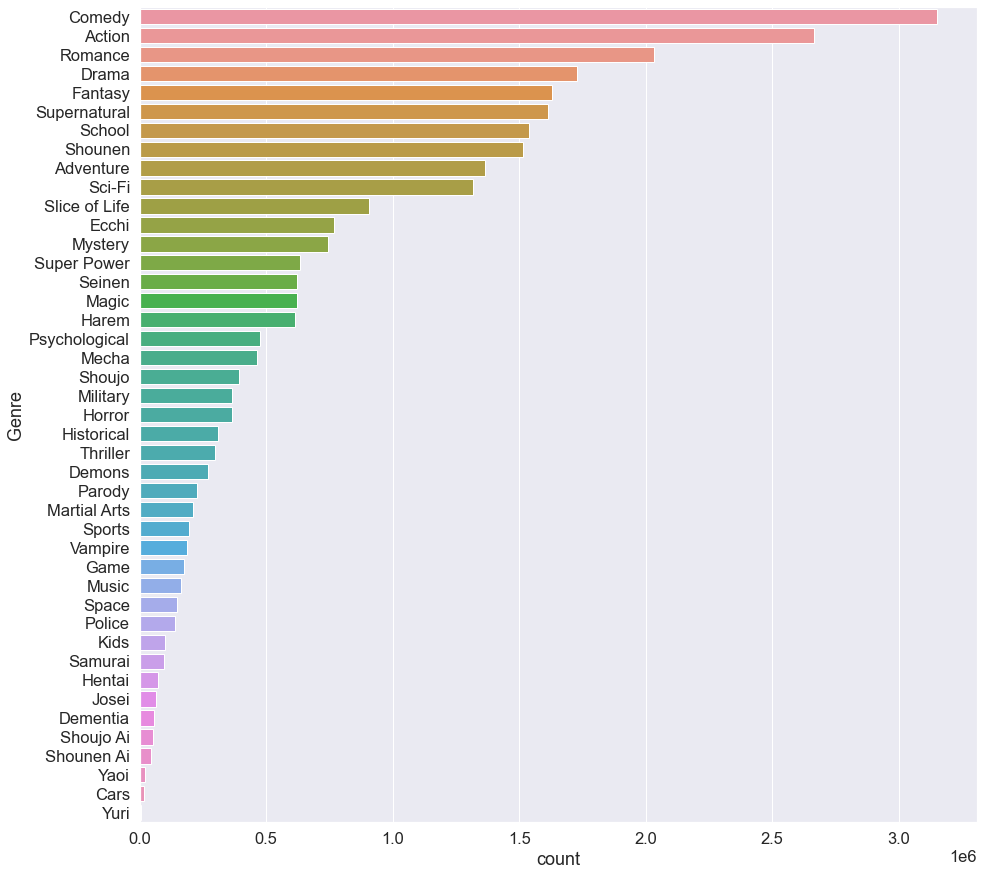

In [199]:
all_genres1=all_genres1.sort_values(by='count',ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(all_genres1['count'],all_genres1['Genre'])

# Data Preprocessing

In [200]:
anime.head()

anime_id                             name  \
0     32281                    Kimi no Na wa   
1      5114  Fullmetal Alchemist Brotherhood   
2     28977                         Gintama°   
3      9253                       SteinsGate   
4      9969                       Gintama039   

                                               genre   type episodes   rating  \
0               Drama, Romance, School, Supernatural  Movie        1 9.370000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64 9.260000   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.250000   
3                                   Sci-Fi, Thriller     TV       24 9.170000   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.160000   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [201]:
genres = anime['genre'].str.split(',', expand=True)
genres.head()

0           1            2              3         4          5   \
0   Drama     Romance       School   Supernatural      None       None   
1  Action   Adventure        Drama        Fantasy     Magic   Military   
2  Action      Comedy   Historical         Parody   Samurai     Sci-Fi   
3  Sci-Fi    Thriller         None           None      None       None   
4  Action      Comedy   Historical         Parody   Samurai     Sci-Fi   

         6     7     8     9     10    11    12  
0      None  None  None  None  None  None  None  
1   Shounen  None  None  None  None  None  None  
2   Shounen  None  None  None  None  None  None  
3      None  None  None  None  None  None  None  
4   Shounen  None  None  None  None  None  None

In [202]:
# considering only first four genres columns 
genres = genres.iloc[:,:4]
genres.columns = ['genre1', 'genre2', 'genre3','genre4']
genres.head()

genre1      genre2       genre3         genre4
0   Drama     Romance       School   Supernatural
1  Action   Adventure        Drama        Fantasy
2  Action      Comedy   Historical         Parody
3  Sci-Fi    Thriller         None           None
4  Action      Comedy   Historical         Parody

In [203]:
updated_rating=anime.copy()

In [204]:
updated_rating = updated_rating.drop('genre', axis=1) 
updated_rating = pd.concat([updated_rating, genres], axis=1)
updated_rating.head()

anime_id                             name   type episodes   rating  \
0     32281                    Kimi no Na wa  Movie        1 9.370000   
1      5114  Fullmetal Alchemist Brotherhood     TV       64 9.260000   
2     28977                         Gintama°     TV       51 9.250000   
3      9253                       SteinsGate     TV       24 9.170000   
4      9969                       Gintama039     TV       51 9.160000   

   members  genre1      genre2       genre3         genre4  
0   200630   Drama     Romance       School   Supernatural  
1   793665  Action   Adventure        Drama        Fantasy  
2   114262  Action      Comedy   Historical         Parody  
3   673572  Sci-Fi    Thriller         None           None  
4   151266  Action      Comedy   Historical         Parody

In [205]:
updated_rating['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [206]:
updated_rating.episodes=updated_rating.episodes.astype('int')

In [207]:
df_cat = updated_rating.select_dtypes(np.object)
df_num = updated_rating.select_dtypes(np.number)

In [208]:
df_dum = pd.get_dummies(df_cat[['type','genre1','genre2','genre3','genre4']])
df_dum.head()

type_Movie  type_Music  type_ONA  type_OVA  type_Special  type_TV  \
0           1           0         0         0             0        0   
1           0           0         0         0             0        1   
2           0           0         0         0             0        1   
3           0           0         0         0             0        1   
4           0           0         0         0             0        1   

   genre1_Action  genre1_Adventure  genre1_Cars  genre1_Comedy  \
0              0                 0            0              0   
1              1                 0            0              0   
2              1                 0            0              0   
3              0                 0            0              0   
4              1                 0            0              0   

   genre1_Dementia  genre1_Demons  genre1_Drama  genre1_Ecchi  genre1_Fantasy  \
0                0              0             1             0               0   
1                0              0             0             0               0   
2                0              0             0             0               0   
3                0              0             0             0               0   
4                0              0             0             0               0   

   genre1_Game  genre1_Harem  genre1_Hentai  genre1_Historical  genre1_Horror  \
0            0             0              0                  0              0   
1            0             0              0                  0              0   
2            0             0              0                  0              0   
3            0             0              0                  0              0   
4            0             0              0                  0              0   

   genre1_Josei  genre1_Kids  genre1_Magic  genre1_Martial Arts  genre1_Mecha  \
0             0            0             0                    0             0   
1             0            0             0                    0             0   
2             0            0             0                    0             0   
3             0            0             0                    0             0   
4             0            0             0                    0             0   

   genre1_Military  genre1_Music  genre1_Mystery  genre1_Parody  \
0                0             0               0              0   
1                0             0               0              0   
2                0             0               0              0   
3                0             0               0              0   
4                0             0               0              0   

   genre1_Police  genre1_Psychological  genre1_Romance  genre1_Samurai  \
0              0                     0               0               0   
1              0                     0               0               0   
2              0                     0               0               0   
3              0                     0               0               0   
4              0                     0               0               0   

   genre1_School  genre1_Sci-Fi  genre1_Seinen  genre1_Shoujo  genre1_Shounen  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              0              0              0              0               0   
3              0              1              0              0               0   
4              0              0              0              0               0   

   genre1_Slice of Life  genre1_Space  genre1_Sports  genre1_Super Power  \
0                     0             0              0                   0   
1                     0             0              0                   0   
2                     0             0              0                   0   
3                     0             0              0                   0 

# Recommendation system 

## Popularity Based recommendation system 

In [221]:
df_data.head()

anime_id           name                                 genre   type  \
0    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
1    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
2    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
3    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   
4    32281  Kimi no Na wa  Drama, Romance, School, Supernatural  Movie   

  episodes  avg_rating  members user_id  user_rating  totalRatingCount  
0        1    9.370000   200630      99     5.000000              1961  
1        1    9.370000   200630     152    10.000000              1961  
2        1    9.370000   200630     244    10.000000              1961  
3        1    9.370000   200630     271    10.000000              1961  
4        1    9.370000   200630     322    10.000000              1961

In [222]:
rating1=df_data[['anime_id','name','genre','avg_rating','totalRatingCount']]
rating1.drop_duplicates(subset=['anime_id'],inplace=True)
rating1.reset_index(drop=True,inplace=True)

In [223]:
rating1.shape

(9890, 5)

In [224]:
# mean rating across all the animes
C = rating1['avg_rating'].mean()
# animes having total rate count greater than 85%
m = rating1['totalRatingCount'].quantile(0.85)
print('m: ', m, 'C: ', C)

m:  987.6499999999996 C:  6.592642062689574


In [225]:
def Iighted_rating(x, m=m, C=C):
    v = x['totalRatingCount']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [226]:
# animes having total rate count greater than 85% is considered into lists_animes
lists_animes =rating1.copy().loc[rating1['totalRatingCount'] >= m]
lists_animes.shape

(1484, 5)

In [227]:
# Define a new feature 'score' and calculate its value with `Iighted_rating()`
lists_animes['score'] = lists_animes.apply(Iighted_rating, axis=1)

In [228]:
lists_animes.head()

anime_id                             name  \
0    32281                    Kimi no Na wa   
1     5114  Fullmetal Alchemist Brotherhood   
2    28977                         Gintama°   
3     9253                       SteinsGate   
4     9969                       Gintama039   

                                               genre  avg_rating  \
0               Drama, Romance, School, Supernatural    9.370000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...    9.260000   
2  Action, Comedy, Historical, Parody, Samurai, S...    9.250000   
3                                   Sci-Fi, Thriller    9.170000   
4  Action, Comedy, Historical, Parody, Samurai, S...    9.160000   

   totalRatingCount    score  
0              1961 8.439724  
1             21494 9.142819  
2              1188 8.043676  
3             17151 9.029663  
4              3115 8.541948

In [229]:
#Sort movies based on score calculated above
lists_animes = lists_animes.sort_values('score', ascending=False)

#Print the top 10 movies
lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)

name  totalRatingCount  avg_rating    score
1     Fullmetal Alchemist Brotherhood             21494    9.260000 9.142819
3                          SteinsGate             17151    9.170000 9.029663
10                Clannad After Story             15518    9.060000 8.912360
13  Code Geass Hangyaku no Lelouch R2             21124    8.980000 8.873365
6                Hunter x Hunter 2011              7477    9.130000 8.833943
15      Sen to Chihiro no Kamikakushi             19481    8.930000 8.817218
19     Code Geass Hangyaku no Lelouch             24125    8.830000 8.742007
16            Shigatsu wa Kimi no Uso              8271    8.920000 8.671733
22                       Cowboy Bebop             13449    8.820000 8.667620
24                      Mononoke Hime             13679    8.810000 8.660683

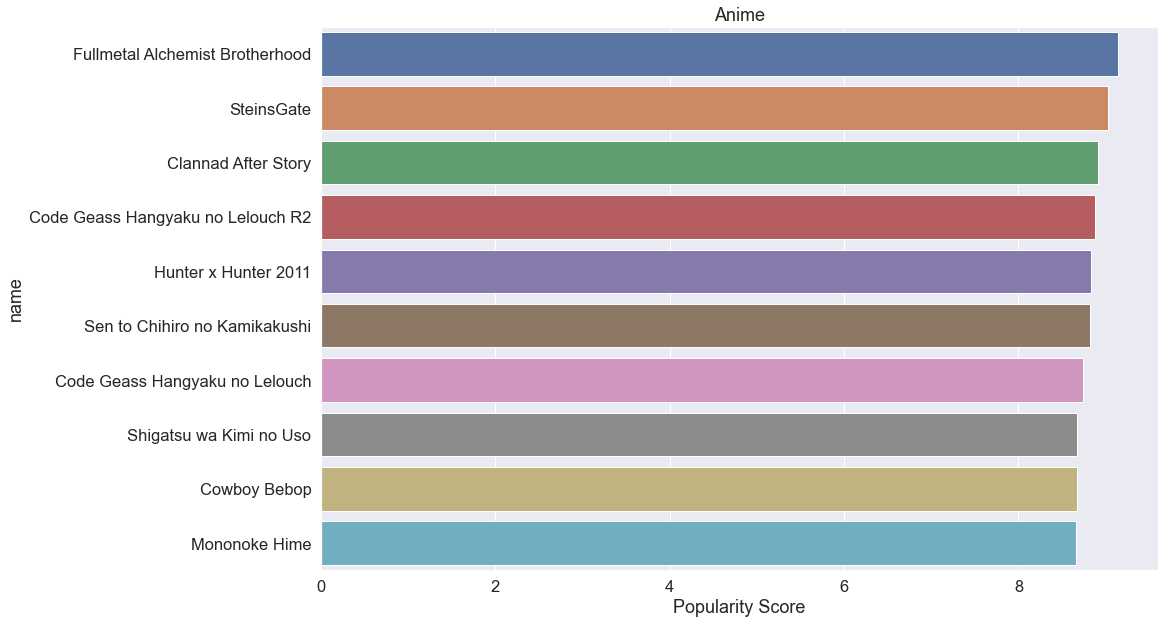

In [230]:
pop=lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)
plt.figure(figsize=(15,10))
sns.barplot(pop['score'],pop['name'])
plt.title('Anime')
plt.xlabel('Popularity Score')
plt.show()

The above plot shows top 10 animes which can be recommended based on trend.

## Content based Recommendation System 

In [231]:
data=anime.copy()
# considering the anime content
data['describe']=data['genre']+data['type']+data['episodes']
data['describe'].fillna(' ')
data.head()

anime_id                             name  \
0     32281                    Kimi no Na wa   
1      5114  Fullmetal Alchemist Brotherhood   
2     28977                         Gintama°   
3      9253                       SteinsGate   
4      9969                       Gintama039   

                                               genre   type episodes   rating  \
0               Drama, Romance, School, Supernatural  Movie        1 9.370000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64 9.260000   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.250000   
3                                   Sci-Fi, Thriller     TV       24 9.170000   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.160000   

   members                                           describe  
0   200630         Drama, Romance, School, SupernaturalMovie1  
1   793665  Action, Adventure, Drama, Fantasy, Magic, Mili...  
2   114262  Action, Comedy, Historical, Parody, Samurai, S...  
3   673572                               Sci-Fi, ThrillerTV24  
4   151266  Action, Comedy, Historical, Parody, Samurai, S...

In [232]:
data.drop_duplicates(subset=['name'],inplace=True)

In [233]:
data.shape

(11806, 8)

In [234]:
data.reset_index(drop=True,inplace=True)

In [235]:
tf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
tf_matrix = tf.fit_transform(data['describe'])
tf_matrix.shape

(11806, 5383)

In [236]:
simil = linear_kernel(tf_matrix, tf_matrix)
simil.shape

(11806, 11806)

In [237]:
id=data['anime_id'].values
simil = pd.DataFrame(simil, index=id, columns=id)
simil.columns = data['name']
simil['anime_name'] = data['name'].values

In [238]:
simil.head()

name   Kimi no Na wa  Fullmetal Alchemist Brotherhood  Gintama°  SteinsGate  \
32281       1.000000                         0.029783  0.000000    0.000000   
5114        0.029783                         1.000000  0.014442    0.000000   
28977       0.000000                         0.014442  1.000000    0.102053   
9253        0.000000                         0.000000  0.102053    1.000000   
9969        0.000000                         0.014442  1.000000    0.102053   

name   Gintama039  Haikyuu Karasuno Koukou VS Shiratorizawa Gakuen Koukou  \
32281    0.000000                                           0.088741        
5114     0.014442                                           0.023594        
28977    1.000000                                           0.011905        
9253     0.102053                                           0.000000        
9969     1.000000                                           0.011905        

name   Hunter x Hunter 2011  Ginga Eiyuu Densetsu  \
32281              0.000000              0.033364   
5114               0.073538              0.080596   
28977              0.015874              0.082382   
9253               0.000000              0.122616   
9969               0.015874              0.082382   

name   Gintama Movie Kanketsuhen  Yorozuya yo Eien Nare  Gintama039 Enchousen  \
32281                                          0.000000              0.000000   
5114                                           0.015371              0.014563   
28977                                          0.797502              0.755570   
9253                                           0.108618              0.102907   
9969                                           0.797502              0.755570   

name   Clannad After Story  Koe no Katachi  Gintama  \
32281             0.077592        0.121389 0.000000   
5114              0.107821        0.032274 0.013406   
28977             0.000000        0.000000 0.695551   
9253              0.000000        0.000000 0.094732   
9969              0.000000        0.000000 0.695551   

name   Code Geass Hangyaku no Lelouch R2  Haikyuu Second Season  \
32281                           0.030484               0.098630   
5114                            0.089494               0.026223   
28977                           0.090054               0.013231   
9253                            0.112034               0.000000   
9969                            0.090054               0.013231   

name   Sen to Chihiro no Kamikakushi  Shigatsu wa Kimi no Uso  \
32281                       0.221786                 0.225566   
5114                        0.160466                 0.023048   
28977                       0.000000                 0.000000   
9253                        0.000000                 0.000000   
9969                        0.000000                 0.000000   

name   Mushishi Zoku Shou 2nd Season  Ookami Kodomo no Ame to Yuki  \
32281                       0.000000                      0.000000   
5114                        0.034745                      0.036579   
28977                       0.034515                      0.000000   
9253                        0.000000                      0.000000   
9969                        0.034515                      0.000000   

name   Code Geass Hangyaku no Lelouch  Hajime no Ippo  \
32281                        0.046537        0.036555   
5114                         0.064197        0.025489   
28977                        0.084722        0.012861   
9253                         0.105400        0.000000   
9969                         0.084722        0.012861   

name   Rurouni Kenshin Meiji Kenkaku Romantan  Tsuiokuhen  Cowboy Bebop  \
32281                                           0.066467       0.038148   
5114                                            0.033998       0.112295   
28977                                           0.049689       0.126114   
9253                                            0.000000       0.14

In [239]:
if([simil.anime_name.value_counts()>1]==True):
    print('There are duplicates rows')
else:
    print('There are no duplicate rows')

There are no duplicate rows


In [240]:
# user defined function to recommend animes based on genre and type
def content_rec(name):
    idx = simil[simil['anime_name']==name]
    idx = idx.drop('anime_name', axis=1).T
    idx.columns = ['similar_val']
    idx = idx.sort_values(by='similar_val', ascending=False)
    return idx

In [241]:
content_rec('Kimi no Na wa').head(10)

similar_val
name                                               
Kimi no Na wa                              1.000000
Aura Maryuuin Kouga Saigo no Tatakai       0.944220
Harmonie                                   0.715831
Hitohira                                   0.442827
Umi ga Kikoeru                             0.435885
Clannad Mou Hitotsu no Sekai Tomoyohen     0.435885
Air Movie                                  0.434257
Kimi no Iru Machi Tasogare Kousaten        0.424720
Wind A Breath of Heart TV                  0.422782
Ushinawareta Mirai wo Motomete             0.420407

The above output recommend the similar animes which is almost same genre and type.

## Collaberative filtering Recommendation System

In [242]:
df.shape

(6337137, 9)

In [243]:
df.duplicated(subset=['user_id','name']).sum()

31779

In [244]:
df1=df.copy()
df1.drop_duplicates(subset=['user_id','name'],inplace=True)

In [245]:
df1.reset_index(drop=True,inplace=True)

In [246]:
counts = df1['user_id'].value_counts()
anime_feature = df1[df1['user_id'].isin(counts[counts >= 500].index)]

In [247]:
anime_feature.shape

(989534, 9)

In [248]:
# user-item matrix
df_pivot = anime_feature.pivot(index='name', columns='user_id', values='user_rating')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

user_id         226      271      294      392      446      478      661    \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         741      771      786      958      1019     1145     1176   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         1191     1287     1344     1456     1497     1504     1522   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         8.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         1530     1720     1822     1984     2200     2273     2297   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         2378     2632     2695     2701     2810     2820     2951   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         3040     3117     3124     3127     3193     3203     3476   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         3500     3557     3569     3597     3657     4064     4102   \
name                                                                          
0            0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0008         0.000000 0.000000 4.000000 0.000000 0.000000 0.000000 0.000000   
001          0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
009 ReCyborg 0.000000 7.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
0091         5.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   

user_id         4177     4215     4350     4468     4512     4749     4759   \
name                                       

In [249]:
df_pivot.shape

(9539, 1345)

### Memory based Recommendation System (Similar anime) Using KNN

In [250]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(df_pivot)

NearestNeighbors(metric='cosine')

In [251]:
distances, indices = model_knn.kneighbors(df_pivot, n_neighbors=6)

In [252]:
recommend = pd.DataFrame(indices, columns=['anime0', 'anime1', 'anime2', 'anime3', 'anime4', 'anime5'])
recommend.head()

anime0  anime1  anime2  anime3  anime4  anime5
0       0    6279    7055    1601    1877    5863
1       1    4278    4307    4277    4066    4324
2       2    2412    3420    8035     283    6558
3       3    1463    5195    8342     511     546
4       4       5      64    1261    2810    3074

In [253]:
recommend2 = recommend.copy()
for i in range(0, 6):
    animes = pd.DataFrame(df_pivot.index).reset_index()
    animes = animes.rename(columns={'index':f'anime{i}'})
    recommend2 = pd.merge(recommend2, animes, on=[f'anime{i}'], how='left')
    recommend2 = recommend2.drop(f'anime{i}', axis=1)
    recommend2 = recommend2.rename(columns={'name':f'anime{i}'})

In [254]:
recommend2.head(10)

anime0  \
0                                      0   
1                                   0008   
2                                    001   
3                           009 ReCyborg   
4                                   0091   
5                             0091 RampB   
6                                07Ghost   
7           1000nen Joou Queen Millennia   
8                            1001 Nights   
9  100mannen Chikyuu no Tabi Bander Book   

                                              anime1  \
0                                            Oosouji   
1  Kinyoru Abe Reiji Heikinteki na Salaryman no I...   
2                                Gakuen Senki Muryou   
3                                         Cyborg 009   
4                                         0091 RampB   
5                                               0091   
6                                       Kuroshitsuji   
7                                      Maetel Legend   
8                                             Kataku   
9                      Love Position Halley Densetsu   

                                              anime2  \
0                                         Rusty Nail   
1                                    Kissaten Soudou   
2                                     Hyoutan Suzume   
3             Mardock Scramble The First Compression   
4                                               AIKa   
5  Glass no Kantai La Legende du Vent de l039Univ...   
6                                     Pandora Hearts   
7  Uchuu Koukyoushi Maetel Ginga Tetsudou 999 Gaiden   
8                                           Doujouji   
9             Bremen 4 Jigoku no Naka no Tenshitachi   

                                              anime3  \
0                                          Decorator   
1  Kinyoru Abe Reiji Heikinteki na Salaryman no I...   
2                                        Sun Set Sun   
3                                            Terra e   
4                                Choujuushin Gravion   
5                                        GTaste 2010   
6                                           DGrayman   
7                                    Queen Emeraldas   
8                              Aru Tabibito no Nikki   
9                      Maken Liner 0011 Henshin Seyo   

                                              anime4  \
0                                             Doudou   
1                                     Kaseifu ga Ita   
2                                 Ame no Bus Stophen   
3             Arve Rezzle Kikaijikake no Youseitachi   
4                                       Gun Frontier   
5                                          AIKa Zero   
6                                       Nabari no Ou   
7  Ginga Tetsudou 999 Kimi wa Haha no You ni Aise...   
8                     Aru Tabibito no Nikki Specials   
9                  Ginga Tansa 2100nen Border Planet   

                                      anime5  
0                   Nebula feat Hatsune Miku  
1  Kittychan wo Sagase Toyamashi Stamp Rally  
2                              Pihyara Kouta  
3                                      Asura  
4                                  HeatGuy J  
5                                       AIKa  
6                             Vampire Knight  
7                         Cosmo Warrior Zero  
8                                     Memory  
9                                  Super Kid

The above table shows the 5 similar animes for each anime.

### Association analysis

In [255]:
anime.head()

anime_id                             name  \
0     32281                    Kimi no Na wa   
1      5114  Fullmetal Alchemist Brotherhood   
2     28977                         Gintama°   
3      9253                       SteinsGate   
4      9969                       Gintama039   

                                               genre   type episodes   rating  \
0               Drama, Romance, School, Supernatural  Movie        1 9.370000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64 9.260000   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.250000   
3                                   Sci-Fi, Thriller     TV       24 9.170000   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51 9.160000   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [256]:
rating.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

#### By Type

In [257]:
def get_ar_type(type):
    type_ul=[]
    grouped = rating.groupby("user_id")
    set_type = set(anime[anime["type"] == type]["anime_id"].values)
    print(type+' :',len(set_type))
    
    
    for i in rating['user_id'].unique():
        g = grouped.get_group(i)
        r = g[g['rating']>=6]
        set_trans = set(r['anime_id'].values)
        anime_type = list(set_type.intersection(set_trans)) 
        if len(anime_type)>1:
            type_ul.append(anime_type)
            
            
    association_rules = apriori(type_ul, min_support=0.15, min_confidence=0.4,min_lift=1)
    association_results = list(association_rules)
    
    
    Result=pd.DataFrame(columns=['Previously Watched','Recommended','Support','Confidence','Lift'])
    for item in association_results:
        pair = item[2]
        for i in pair:
            items = str([x for x in i[0]])
            if i[3]!=1:
                Result=Result.append({'Previously Watched':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[0]]),'Recommended':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[1]]),'Support':item[1],'Confidence':i[2],'Lift':i[3]},ignore_index=True)
    Result_ar=Result.sort_values(by='Lift',ascending=False)
    Result_ar=Result_ar.reset_index(drop=True)
    return Result_ar

In [258]:
get_ar_type('Movie').head(10)

Movie : 2258


Previously Watched  \
0  ['Howl no Ugoku Shiro', 'Sen to Chihiro no Kam...   
1                               ['Tonari no Totoro']   
2  ['Tonari no Totoro', 'Sen to Chihiro no Kamika...   
3                            ['Howl no Ugoku Shiro']   
4                            ['Howl no Ugoku Shiro']   
5  ['Mononoke Hime', 'Sen to Chihiro no Kamikakus...   
6  ['Howl no Ugoku Shiro', 'Sen to Chihiro no Kam...   
7                                  ['Mononoke Hime']   
8                               ['Tonari no Totoro']   
9                            ['Howl no Ugoku Shiro']   

                                         Recommended  Support  Confidence  \
0                               ['Tonari no Totoro'] 0.151453    0.571773   
1  ['Sen to Chihiro no Kamikakushi', 'Howl no Ugo... 0.151453    0.649516   
2                            ['Howl no Ugoku Shiro'] 0.151453    0.779800   
3  ['Tonari no Totoro', 'Sen to Chihiro no Kamika... 0.151453    0.468728   
4  ['Mononoke Hime', 'Sen to Chihiro no Kamikakus... 0.179896    0.556756   
5                            ['Howl no Ugoku Shiro'] 0.179896    0.750714   
6                                  ['Mononoke Hime'] 0.179896    0.679153   
7  ['Sen to Chihiro no Kamikakushi', 'Howl no Ugo... 0.179896    0.591629   
8                            ['Howl no Ugoku Shiro'] 0.166507    0.714076   
9                               ['Tonari no Totoro'] 0.166507    0.515318   

      Lift  
0 2.452086  
1 2.452086  
2 2.413385  
3 2.413385  
4 2.323366  
5 2.323366  
6 2.233547  
7 2.233547  
8 2.209976  
9 2.209976

As for Index 0 : If a user has Watched and liked `Howl no Ugoku Shiro` and `Sen to Chihiro no Kamikakushi` there is `57%` confidence with `0.15` support he/she will like `Tonari no Totoro`

As for Index 7 : If a user has Watched and liked `Mononoke Hime` there is `59%` confidence with `0.18` support he/she will like `Sen to Chihiro no Kamikakushi`and `Howl no Ugoku Shiro`

In [259]:
Result_tv=get_ar_type('TV')

TV : 3568


In [260]:
def find_anime_ar(name,result):
    temp=result.copy()
    temp['Previously Watched']=temp['Previously Watched'].apply(lambda x:x if name in x else 'different')
    temp=temp[temp['Previously Watched']!='different']
    temp=temp.reset_index(drop=True)
    return temp   

In [261]:
find_anime_ar('Death Note',Result_tv).head(10)

Previously Watched  \
0   ['Code Geass Hangyaku no Lelouch', 'Death Note']   
1  ['Code Geass Hangyaku no Lelouch R2', 'Death N...   
2                 ['Sword Art Online', 'Death Note']   
3  ['Fullmetal Alchemist Brotherhood', 'Death Note']   
4               ['Shingeki no Kyojin', 'Death Note']   
5               ['Shingeki no Kyojin', 'Death Note']   
6   ['Code Geass Hangyaku no Lelouch', 'Death Note']   
7  ['Fullmetal Alchemist Brotherhood', 'Death Note']   
8               ['Shingeki no Kyojin', 'Death Note']   
9   ['Code Geass Hangyaku no Lelouch', 'Death Note']   

                             Recommended  Support  Confidence     Lift  
0  ['Code Geass Hangyaku no Lelouch R2'] 0.235769    0.877368 2.751909  
1     ['Code Geass Hangyaku no Lelouch'] 0.235769    0.983371 2.697496  
2                 ['Shingeki no Kyojin'] 0.173710    0.744382 1.964254  
3     ['Code Geass Hangyaku no Lelouch'] 0.157977    0.674082 1.849083  
4    ['Fullmetal Alchemist Brotherhood'] 0.154251    0.603854 1.845032  
5                   ['Sword Art Online'] 0.173710    0.680034 1.833782  
6    ['Fullmetal Alchemist Brotherhood'] 0.157977    0.587879 1.796223  
7                 ['Shingeki no Kyojin'] 0.154251    0.658182 1.736794  
8     ['Code Geass Hangyaku no Lelouch'] 0.151966    0.594909 1.631903  
9                 ['Shingeki no Kyojin'] 0.151966    0.565510 1.492253

As for Index 0 : If a user has Watched and liked `Code Geass 1st season` and `Death Note` there is `87.7%` confidence with `0.235` support he/she will like `Code Geass 2nd season`

As for Index 5 : If a user has Watched and liked `Shingeki no Kyojin` and `Death Note` there is `68%` confidence with `0.17` support he/she will like `Sword Art Online`

#### By Genre 

In [262]:
anime.reset_index(drop=True,inplace=True)

In [263]:
def get_ar_genre(genre):
    genre_ul=[]
    set_genre=set()
    for i in range(len(anime)):
        str_genre = anime.loc[i, 'genre']
        if pd.isnull(str_genre):
            continue
        A = str_genre.strip().split(", ")
        for j in A:
            if j==genre:
                set_genre.add(anime.loc[i,"anime_id"])
    
    
    grouped = rating.groupby("user_id")
    print(genre+' :',len(set_genre))
    
    for i in rating['user_id'].unique():
        g = grouped.get_group(i)
        r = g[g['rating']>=6]
        set_trans = set(r['anime_id'].values)
        anime_genre = list(set_genre.intersection(set_trans)) 
        if len(anime_genre)>1:
            genre_ul.append(anime_genre)
            
            
    association_rules = apriori(genre_ul, min_support=0.15, min_confidence=0.5,min_lift=1)
    association_results = list(association_rules)
    
    
    Result=pd.DataFrame(columns=['Previously Watched','Recommended','Support','Confidence','Lift'])
    for item in association_results:
        pair = item[2]
        for i in pair:
            items = str([x for x in i[0]])
            if i[3]!=1:
                Result=Result.append({'Previously Watched':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[0]]),'Recommended':str([anime[anime['anime_id']==x].reset_index().loc[0,'name'] for x in i[1]]),'Support':item[1],'Confidence':i[2],'Lift':i[3]},ignore_index=True)
    Result_ar=Result.sort_values(by='Lift',ascending=False)
    Result_ar=Result_ar.reset_index(drop=True)
    return Result_ar

In [264]:
get_ar_genre('Comedy').head(10)

Comedy : 4483


Previously Watched      Recommended  Support  Confidence     Lift
0          ['Clannad']     ['Toradora'] 0.177051    0.608959 1.847174
1         ['Toradora']      ['Clannad'] 0.177051    0.537055 1.847174
2  ['No Game No Life']  ['Angel Beats'] 0.160876    0.655863 1.783101
3      ['Angel Beats']      ['Clannad'] 0.190108    0.516848 1.777671
4          ['Clannad']  ['Angel Beats'] 0.190108    0.653865 1.777671
5         ['Toradora']  ['Angel Beats'] 0.201144    0.610136 1.658784
6      ['Angel Beats']     ['Toradora'] 0.201144    0.546852 1.658784

As for Index 0 : If a user has Watched and liked `Clannad` there is `61%` confidence with `0.18` support he/she will like `Toradora`

As for Index 2 : If a user has Watched and liked `No Game No Life` there is `65%` confidence with `0.16` support he/she will like `Angel Beats`

In [265]:
result_action=get_ar_genre('Action')

Action : 2748


In [266]:
result_action.head()

Previously Watched  \
0                                       ['FateZero']   
1                            ['FateZero 2nd Season']   
2              ['Code Geass Hangyaku no Lelouch R2']   
3  ['Fullmetal Alchemist Brotherhood', 'Code Geas...   
4  ['Angel Beats', 'Code Geass Hangyaku no Lelouch']   

                                         Recommended  Support  Confidence  \
0                            ['FateZero 2nd Season'] 0.162466    0.829580   
1                                       ['FateZero'] 0.162466    0.973289   
2  ['Fullmetal Alchemist Brotherhood', 'Code Geas... 0.185784    0.549370   
3              ['Code Geass Hangyaku no Lelouch R2'] 0.185784    0.908563   
4              ['Code Geass Hangyaku no Lelouch R2'] 0.178999    0.905424   

      Lift  
0 4.969800  
1 4.969800  
2 2.686648  
3 2.686648  
4 2.677367

In [267]:
find_anime_ar('Fullmetal Alchemist',result_action).head(10)

Previously Watched  \
0  ['Fullmetal Alchemist Brotherhood', 'Code Geas...   
1  ['Fullmetal Alchemist', 'Code Geass Hangyaku n...   
2  ['Code Geass Hangyaku no Lelouch R2', 'Fullmet...   
3  ['Code Geass Hangyaku no Lelouch R2', 'Fullmet...   
4                            ['Fullmetal Alchemist']   
5                ['Fullmetal Alchemist Brotherhood']   
6                ['Fullmetal Alchemist Brotherhood']   
7                ['Fullmetal Alchemist Brotherhood']   
8                ['Fullmetal Alchemist Brotherhood']   
9                ['Fullmetal Alchemist Brotherhood']   

                                         Recommended  Support  Confidence  \
0              ['Code Geass Hangyaku no Lelouch R2'] 0.185784    0.908563   
1              ['Code Geass Hangyaku no Lelouch R2'] 0.169121    0.875864   
2                 ['Code Geass Hangyaku no Lelouch'] 0.169121    0.985492   
3                 ['Code Geass Hangyaku no Lelouch'] 0.185784    0.981348   
4                ['Fullmetal Alchemist Brotherhood'] 0.201178    0.593291   
5                            ['Fullmetal Alchemist'] 0.201178    0.580722   
6  ['Code Geass Hangyaku no Lelouch R2', 'Code Ge... 0.185784    0.536286   
7              ['Code Geass Hangyaku no Lelouch R2'] 0.189315    0.546479   
8                 ['Code Geass Hangyaku no Lelouch'] 0.204481    0.590258   
9                             ['Shingeki no Kyojin'] 0.209607    0.605054   

      Lift  
0 2.686648  
1 2.589956  
2 2.552212  
3 2.541479  
4 1.712599  
5 1.712599  
6 1.625069  
7 1.615956  
8 1.528641  
9 1.512033

As for Index 4 : If a user has Watched and liked `Fullmetal Alchemist` there is `59%` confidence with `0.2` support he/she will like `Fullmetal Alchemist  Brotherhood`

As for Index 9 : If a user has Watched and liked `Fullmetal Alchemist Brotherhood` there is `60%` confidence with `0.21` support he/she will like `Shingeki no Kyojin`

# Conclusion


- For a new user popularity based and content based recommender works well, later based on user activities, collaborative based and association recommenders performs better.

- A  better  anime  recommendation  system is when I consider user  watch  history.So collaborative based filtering (model-based) recommendation model would be best for recommending animes to the users.